# Generalized linear models (GLMs) of neural responses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

## Excercise 1

We define the gaussain model code from the lesson as a function of duration and noise, since these parameters will be changed. 

In [31]:
dt = .1
std_dev = 1
vf_size = (15,15)

size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc

xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))

In [32]:
def Gaussmodel(duration, noise_variance):
    n_bins = round(duration / float(dt))
    
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    
    #noise_variance = 1
    offset = 2.

    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    rate = ks

    # add Gaussian noise centered around the "true" rate for each bin
    rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

    K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
    K_hat = K_hat[:-1].reshape(vf_size)
    return K, K_hat
    

Then the Pearson correlation is defined.

In [33]:
def cc(Ktrue, Khat):
    pearson = np.inner(Ktrue, Khat) / (np.linalg.norm(Ktrue) * np.linalg.norm(Khat))
    return pearson

A for loop is used to run the gaussian model at different durations and collect the mean pearson correlation.

In [34]:
meanmean = np.array([]) # Collection of the mean pearson correlations, one for each duration
for j in range(8): 
    p = 2**j # The different durations
    
    mean = np.array([])
    for i in range(10): # Running each duration 10 times
        values = Gaussmodel(p, 1)
        corr = cc(values[0], values[1])
        mean1 = np.mean(corr) # Taking the mean of the Pearson correlation for each run, since Pearson correlation is an array of values
        mean = np.append(mean, mean1)
    
    mean2 = np.mean(mean) # Taking the mean of the means
    meanmean = np.append(meanmean,mean2)


In [35]:
t = [5, 10, 20, 40, 80, 160, 320, 640]

Text(0, 0.5, 'Pearson correlation')

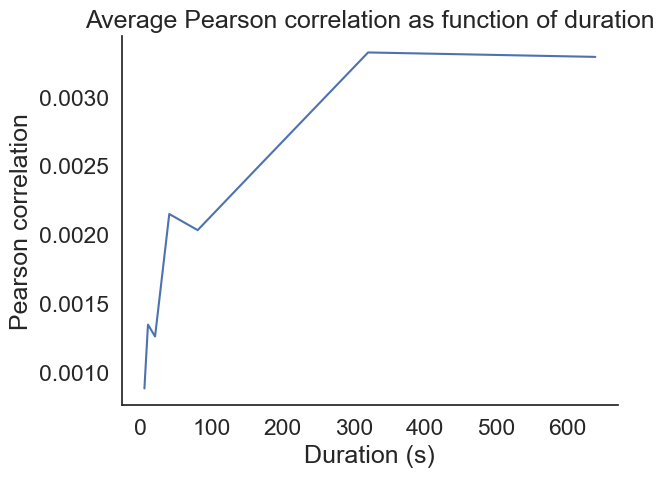

In [36]:
plt.plot(t, meanmean)
plt.title('Average Pearson correlation as function of duration')
plt.xlabel('Duration (s)')
plt.ylabel('Pearson correlation')

As can be seen from the above plot, the Pearson correlation increases with the duration, but this increase decreases exponentially. Also the correlation value is close to 0 which indicates the fit is not very good.

## Exercise 2

Here the function defined earlier is used again, but instead of varying the duration, the noise is varied. The calculation is similar to the previous exercise.

In [37]:
stdstd = np.array([])
meanmean2 = np.array([])
for j in range(6):
    p = 2*j
    
    nomean = np.array([])
    for i in range(10):
        values = Gaussmodel(100, p)
        corr = cc(values[0], values[1])
       
        nomean = np.append(nomean, corr)
    
    mean2 = np.mean(nomean)
    stdiv = np.std(nomean)
    
    meanmean2 = np.append(meanmean2,mean2)
    stdstd = np.append(stdstd, stdiv)

In [38]:
noise = [0,2,4,6,8,10]

Text(0, 0.5, 'Pearson Correlation')

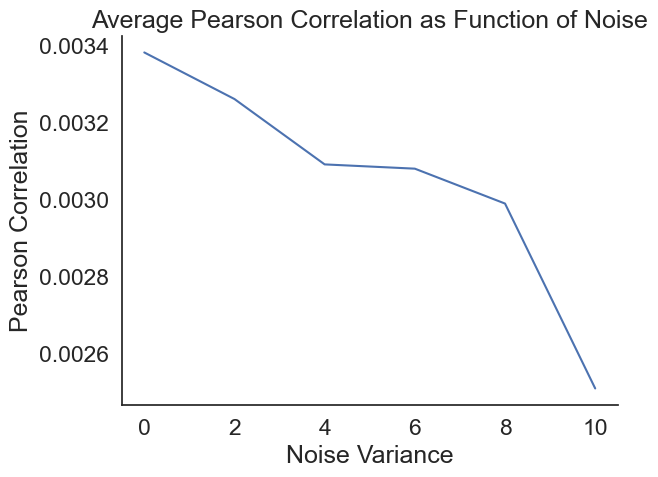

In [39]:
plt.plot(noise, meanmean2)
plt.title('Average Pearson Correlation as Function of Noise')
plt.xlabel('Noise Variance')
plt.ylabel('Pearson Correlation')

The Pearson correlation seems to have an inverse linear relationship with the noise variance, but again very low correlation values.

Text(0, 0.5, 'Standard Deviation')

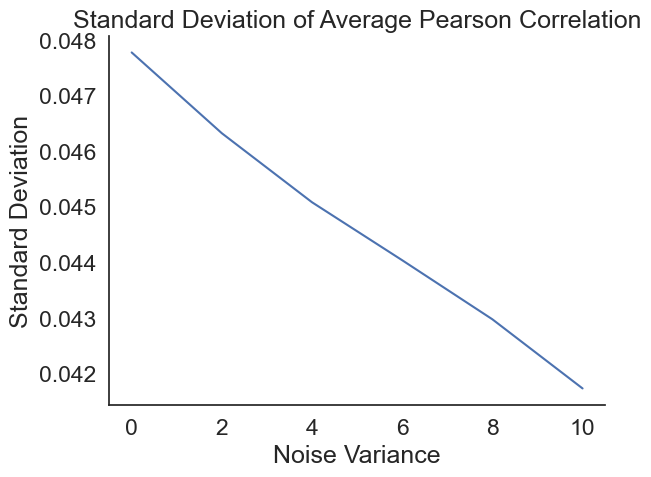

In [40]:
plt.plot(noise, stdstd)
plt.title('Standard Deviation of Average Pearson Correlation')
plt.xlabel('Noise Variance')
plt.ylabel('Standard Deviation')

## Exercise 3

We have:

\begin{equation}
    \log P(R | \lambda) = \sum_t r_t\log \lambda_t + \sum_t r_t\log \Delta - \sum_t \log r_t! - \sum_t \lambda_t \Delta.
\end{equation}

Where $$ \lambda_t = f(\mathbf{k}^T \mathbf{s}_t) $$

The derivative w.r.t to $\mathbf{k}$ is

\begin{align}
    \frac{\partial{\log P}}{\partial{\mathbf{k}}} &= \sum_t \frac{\partial{r_t \log \lambda_t}}{\partial{\mathbf{k}}} + \sum_t \frac{\partial{r_t \log \Delta}}{\partial{\mathbf{k}}} - \sum_t \frac{\partial{r_t \log r_t!}}{\partial{\mathbf{k}}} - \Delta \sum_t \frac{\partial{\lambda_t}}{\partial{\mathbf{k}}} \\
    &= \sum_t \frac{\partial{r_t \log \lambda_t}}{\partial{\mathbf{k}}} - \Delta \sum_t \frac{\partial{\lambda_t}}{\partial{\mathbf{k}}}
\end{align}

The $\sum_t r_t\log \Delta$ and $\sum_t \log r_t!$ term disappear when taking the derivate, so these can be ignored the other two terms are required for likelihood maximization since they do not disappear. 

## Exercise 4

### A

First the definitions from the lesson are taken.

In [41]:
def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]

    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

In [42]:
from scipy.optimize import minimize


# define functions for minimisation
def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

Then, similarly to the first to exercises, the code for the Poisson model is defined as a function of duration and spike rate, to easily vary these inputs.

In [43]:
def PoissonModel(duration, spike_rate):
    n_bins = round(duration / float(dt))

    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    
    offset = 2.
    
    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
    # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
    # across all bins gives the expected number of spikes for the whole draw.
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times,
                                bins=np.arange(n_bins+1)*dt)[0]

    
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

    K_est = res.x
    return K_est

Run the code for the different durations and gather the values for the K estimations

In [44]:
K_estimates = np.array([])
for i in [10,20,50,100,200]:
    values = PoissonModel(i,5)
    K_estimates = np.append(K_estimates, values)
    

In [45]:
splitted = np.split(K_estimates, 5) # split the gathered values into lists for each duration

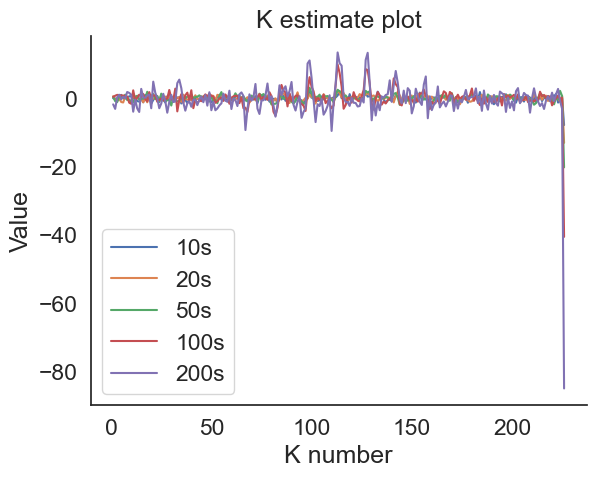

In [46]:
plt.plot(np.linspace(1,226, 226), splitted[0], label = '10s')
plt.plot(np.linspace(1,226, 226), splitted[1], label = '20s')
plt.plot(np.linspace(1,226, 226), splitted[2], label = '50s')
plt.plot(np.linspace(1,226, 226), splitted[3], label = '100s')
plt.plot(np.linspace(1,226, 226), splitted[4], label = '200s')
plt.title('K estimate plot')
plt.xlabel('K number')
plt.ylabel('Value')
plt.legend()
plt.show()

There seem to be some extreme values at the end, so to get a clearer plot these are excluded below.

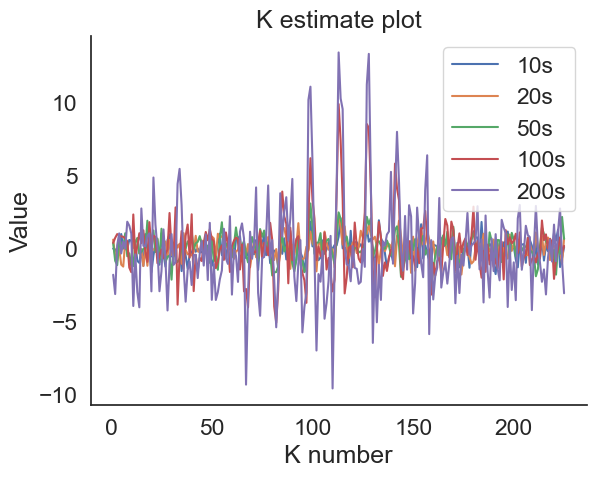

In [47]:
plt.plot(np.linspace(1,225, 225), splitted[0][:225], label = '10s')
plt.plot(np.linspace(1,225, 225), splitted[1][:225], label = '20s')
plt.plot(np.linspace(1,225, 225), splitted[2][:225], label = '50s')
plt.plot(np.linspace(1,225, 225), splitted[3][:225], label = '100s')
plt.plot(np.linspace(1,225, 225), splitted[4][:225], label = '200s')
plt.title('K estimate plot')
plt.xlabel('K number')
plt.ylabel('Value')
plt.legend()
plt.show()

The Pearson correlation is used again to determine the goodness of the fit.

In [48]:
Pearson = np.array([])
for i in [10,20,50,100,200]:
    values = PoissonModel(i,5)
    pearson1 = np.inner(K.ravel(), values[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(values[:-1]))
    Pearson = np.append(Pearson, pearson1)

Text(0, 0.5, 'Correlation Value')

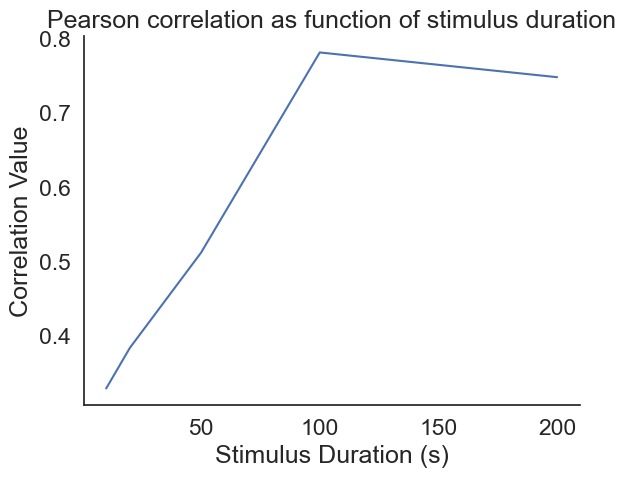

In [49]:
plt.plot([10,20,50,100,200], Pearson)
plt.title('Pearson correlation as function of stimulus duration')
plt.xlabel('Stimulus Duration (s)')
plt.ylabel('Correlation Value')

The Pearson correlation increases with stimulus duration, as was with the Gaussian model, but in this case the values are closer to one, which indicates a reasonably good fit.

### B

In [50]:
Pearsonrate = np.array([])
for i in [5,10,15,20,25,30,35,40]:
    values = PoissonModel(100,i)
    pearson1 = np.inner(K.ravel(), values[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(values[:-1]))
    Pearsonrate = np.append(Pearsonrate, pearson1)

Text(0, 0.5, 'Correlation Value')

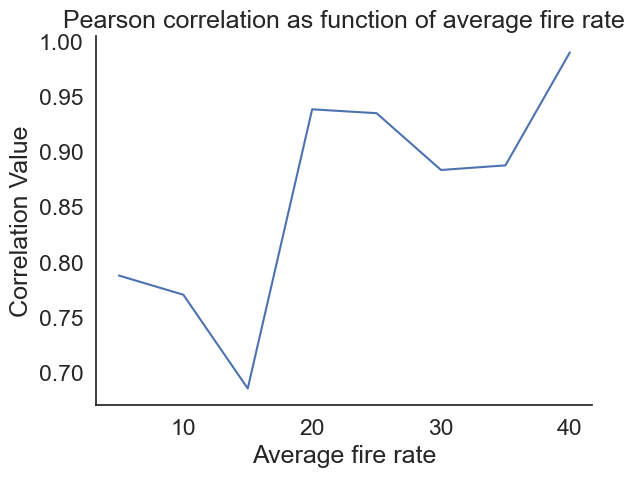

In [51]:
plt.plot([5,10,15,20,25,30,35,40], Pearsonrate)
plt.title('Pearson correlation as function of average fire rate')
plt.xlabel('Average fire rate')
plt.ylabel('Correlation Value')

In general the Pearson correlation goes up with fire rate, so the goodness of the fit increases, but sometimes a dip is observed in the plot.